In [95]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
# Load the results from the JSON file
results_df = pd.read_json("/content/drive/MyDrive/sentiment_analysis/deepseek_ai_job_analysis.json")

# Display the first few rows of the loaded DataFrame
print(results_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22007 entries, 0 to 22006
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   article_id              22007 non-null  int64 
 1   date                    22007 non-null  int64 
 2   job_roles               22007 non-null  object
 3   policy_recommendations  22007 non-null  object
dtypes: int64(2), object(2)
memory usage: 687.8+ KB
None


In [100]:
results_df.iloc[20443].to_dict()

{'article_id': 20678,
 'date': 1746403200000,
 'job_roles': [{'role': 'HR professional',
   'industry': 'human resources',
   'ai_impact': 'transformed_role',
   'evidence': 'your hr teams can use agentic ai to streamline hiring personalize employee development and plan for future skills needs.',
   'sentiment_score': 0.5,
   'confidence': 0.7000000000000001}],
 'policy_recommendations': []}

In [101]:
# Convert the 'date' column from timestamp (int64) to datetime objects
results_df['date'] = pd.to_datetime(results_df['date'], unit='ms') # Assuming the int64 is milliseconds

# Convert the 'date' column to show only the date
results_df['date'] = results_df['date'].dt.date

In [102]:
print(results_df.head(1))

   article_id        date                                          job_roles  \
0           1  2014-08-06  [{'role': 'parking lot attendant', 'industry':...   

  policy_recommendations  
0                     []  


In [103]:
results_df['date'] = pd.to_datetime(results_df['date'])
# Filter for dates after 2025 (i.e., >= 2025-01-01)
results_df = results_df[results_df['date'] <= '2025-12-12']

print(f"Number of rows after deletion: {len(results_df)}")

Number of rows after deletion: 21996


In [104]:
# Flatten with date extraction
job_rows = []
policy_rows = []

# Iterate over the rows of the DataFrame using iterrows()
for index, row in results_df.iterrows():
    article_id = row["article_id"]
    date = row["date"] # Extract the date

    if row["job_roles"]:
        for jr in row["job_roles"]:
            job_rows.append({
                "article_id": article_id,
                "date": date,  # Include date
                "role": jr.get("role"), # Use .get for safety
                "industry": jr.get("industry"), # Use .get for safety
                "ai_impact": jr.get("ai_impact"), # Use .get for safety
                "evidence": jr.get("evidence"), # Use .get for safety
                "sentiment_score": jr.get("sentiment_score"), # Use .get for safety
                "confidence": jr.get("confidence") # Use .get for safety
            })

    if row["policy_recommendations"]:
        for pr in row["policy_recommendations"]:
            policy_rows.append({
                "article_id": article_id,
                "date": date, # Include date
                "category": pr.get("category"), # Use .get for safety
                "recommendations": pr.get("recommendations") # Use .get for safety
            })

df_jobs = pd.DataFrame(job_rows)
df_policies = pd.DataFrame(policy_rows)

print(f"Total roles extracted: {len(df_jobs)}")
print(f"Total policy categories: {len(df_policies)}")

Total roles extracted: 35335
Total policy categories: 11744


In [105]:
print("df_jobs", df_jobs.info())
print("**************************")
print("df_policies", df_policies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35335 entries, 0 to 35334
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   article_id       35335 non-null  int64         
 1   date             35335 non-null  datetime64[ns]
 2   role             34996 non-null  object        
 3   industry         33522 non-null  object        
 4   ai_impact        34783 non-null  object        
 5   evidence         35197 non-null  object        
 6   sentiment_score  34612 non-null  object        
 7   confidence       34731 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 2.2+ MB
df_jobs None
**************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11744 entries, 0 to 11743
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   article_id       11744 non-null  i

In [106]:
def optimize_dataframes(df_jobs, df_policies):
    # Create copies to avoid modifying the input DataFrames
    df_jobs = df_jobs.copy()
    df_policies = df_policies.copy()

    # Convert dates to datetime format and keep only Year-Month
    df_jobs.loc[:, 'date'] = pd.to_datetime(df_jobs['date']).dt.to_period('M').dt.to_timestamp()
    df_policies.loc[:, 'date'] = pd.to_datetime(df_policies['date']).dt.to_period('M').dt.to_timestamp()

    # Drop rows with null values in all columns except 'industry'
    columns_to_check = df_jobs.columns.difference(['industry'])
    df_jobs = df_jobs.dropna(subset=columns_to_check).copy()

    # For df_policies, drop nulls in all columns (no exceptions needed)
    df_policies = df_policies.dropna().copy()

    # Convert sentiment_score and confidence to numeric, coercing errors
    df_jobs.loc[:, 'sentiment_score'] = pd.to_numeric(df_jobs['sentiment_score'], errors='coerce')
    df_jobs.loc[:, 'confidence'] = pd.to_numeric(df_jobs['confidence'], errors='coerce')

    # Fill missing values in industry only (since we've dropped nulls in other columns)
    df_jobs.loc[:, 'industry'] = df_jobs['industry'].fillna('unknown')

    # Fill any remaining nulls in numeric columns (from coercion)
    df_jobs.loc[:, 'sentiment_score'] = df_jobs['sentiment_score'].fillna(
        df_jobs['sentiment_score'].median()
    )
    df_jobs.loc[:, 'confidence'] = df_jobs['confidence'].fillna(
        df_jobs['confidence'].mean()
    )

    # Round sentiment_score and confidence to 2 decimal places
    df_jobs.loc[:, 'sentiment_score'] = df_jobs['sentiment_score'].round(2)
    df_jobs.loc[:, 'confidence'] = df_jobs['confidence'].round(2)

    # Optimize dtypes using .loc
    df_jobs.loc[:, 'article_id'] = df_jobs['article_id'].astype('int32')
    df_jobs.loc[:, 'sentiment_score'] = df_jobs['sentiment_score'].astype('float32')
    df_jobs.loc[:, 'confidence'] = df_jobs['confidence'].astype('float32')
    df_policies.loc[:, 'article_id'] = df_policies['article_id'].astype('int32')

    # Convert to category dtype where appropriate
    for col in ['role', 'industry', 'ai_impact', 'evidence']:
        if df_jobs[col].nunique() / len(df_jobs) < 0.5:
            df_jobs.loc[:, col] = df_jobs[col].astype('category')

    # Handle recommendations column separately (since it contains lists)
    if isinstance(df_policies['recommendations'].iloc[0], list):
        df_policies.loc[:, 'recommendations'] = df_policies['recommendations'].apply(
            lambda x: ', '.join(x) if isinstance(x, list) else x
        )

    return df_jobs, df_policies
# Usage:
df_jobs, df_policies = optimize_dataframes(df_jobs, df_policies)

In [107]:
print("df_jobs", df_jobs.info())
print("**************************")
print("df_policies", df_policies.info())

<class 'pandas.core.frame.DataFrame'>
Index: 34043 entries, 0 to 35334
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   article_id       34043 non-null  int64         
 1   date             34043 non-null  datetime64[ns]
 2   role             34043 non-null  object        
 3   industry         34043 non-null  object        
 4   ai_impact        34043 non-null  object        
 5   evidence         34043 non-null  object        
 6   sentiment_score  34043 non-null  object        
 7   confidence       34043 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 2.3+ MB
df_jobs None
**************************
<class 'pandas.core.frame.DataFrame'>
Index: 11743 entries, 0 to 11743
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   article_id       11743 non-null  int64      

In [108]:
df_jobs.iloc[3].to_dict()

{'article_id': 1,
 'date': Timestamp('2014-08-01 00:00:00'),
 'role': 'document review lawyer',
 'industry': 'legal',
 'ai_impact': 'obsolete_role',
 'evidence': 'the field within which i work currently employs many thousands to review documents. they are already being replaced by predictive coding algorithms. by those jobs will not exist for any but the most opaque documents and thus there will be many thousands of lawyers out of work.',
 'sentiment_score': -0.699999988079071,
 'confidence': 0.8999999761581421}

In [109]:
# Changes for rounding sentiment_score and confidence were made in cell aLaxuNIs9TbI

In [110]:
df_policies.iloc[0].to_dict()

{'article_id': 2,
 'date': Timestamp('2014-08-01 00:00:00'),
 'category': 'training_upskilling',
 'recommendations': 'our educational system is not adequately preparing us for work of the future and our political and economic institutions are poorly equipped to handle these hard choices.'}

In [111]:
import warnings
# Filter out FutureWarnings from seaborn
warnings.filterwarnings('ignore', category=FutureWarning)

In [112]:
# Display unique values in the 'ai_impact' column
print("Unique AI Impact Categories:")
print(df_jobs['ai_impact'].unique())

Unique AI Impact Categories:
['obsolete_role' 'transformed_role' 'at_risk' 'emerging_role' 'augmented'
 'low_risk' 'null' 'revived_role' 'less_affected' 'deskilled_role' 'safe'
 'precarious_role' 'growing' 'lower_exposure' 'polarised_automatable'
 'low_exposure' 'persistent_role' 'exploited_role' 'resilient'
 'minimal_automation']


In [113]:
# Count the occurrences of each AI impact category
ai_impact_counts = df_jobs['ai_impact'].value_counts()

# Display the list of AI impact categories and their counts
print("Count of each AI Impact Category:")
print(ai_impact_counts)

Count of each AI Impact Category:
ai_impact
augmented                9498
emerging_role            9393
transformed_role         7170
at_risk                  6734
obsolete_role            1152
null                       37
low_risk                   20
safe                       14
lower_exposure              4
growing                     3
persistent_role             3
deskilled_role              2
resilient                   2
precarious_role             2
less_affected               2
low_exposure                2
exploited_role              2
revived_role                1
polarised_automatable       1
minimal_automation          1
Name: count, dtype: int64


In [114]:
# Display unique values in the 'category' column of df_policies
print("Unique Policy Categories:")
print(df_policies['category'].unique())

Unique Policy Categories:
['training_upskilling' 'economic_transition_support' 'worker_protection'
 'ai_governance_ethics' 'innovation_incentives'
 'international_cooperation' 'data_privacy_security' 'education'
 'communication' 'feedback' 'education_reform' 'diversity_and_inclusion'
 'educational_reform' 'policy_support' 'change_management' 'collaboration'
 'education_and_skill_development' 'workforce_development'
 'equitable_access' 'national_security']


In [115]:
# Count the occurrences of each policy category
policy_category_counts = df_policies['category'].value_counts()

# Display the list of policy categories and their counts
print("Count of each Policy Category:")
print(policy_category_counts)

Count of each Policy Category:
category
training_upskilling                5057
ai_governance_ethics               4037
worker_protection                  1248
economic_transition_support         998
innovation_incentives               381
education                             5
education_reform                      4
international_cooperation             1
data_privacy_security                 1
communication                         1
feedback                              1
diversity_and_inclusion               1
educational_reform                    1
policy_support                        1
change_management                     1
collaboration                         1
education_and_skill_development       1
workforce_development                 1
equitable_access                      1
national_security                     1
Name: count, dtype: int64


In [116]:
print("Unique roles:")
df_jobs['role'].unique()

Unique roles:


array(['parking lot attendant', 'call center worker',
       'retail checkout worker', ..., 'risk compliance professional',
       'tax accountant', 'peer mentor'], dtype=object)

In [117]:
# Count the occurrences of each role
role_counts = df_jobs['role'].value_counts()

# Display the list of roles and their counts
print("Count of each job role:")
print(role_counts)

Count of each job role:
role
AI ethicist                                853
HR professional                            656
journalist                                 593
data scientist                             522
graphic designer                           503
                                          ... 
Customer support manager                     1
Human reviewers                              1
Office workers                               1
IT teams                                     1
systems/cloud infrastructure specialist      1
Name: count, Length: 8994, dtype: int64


In [118]:
# Count the occurrences of each industry
industry_counts = df_jobs['industry'].value_counts()

# Display the list of industries and their counts
print("Count of each industry:")
print(industry_counts)

Count of each industry:
industry
tech                          10813
healthcare                     3010
education                      2555
unknown                        1440
media                          1253
                              ...  
multinational corporations        1
crafts                            1
film and tv                       1
print media                       1
design and marketing              1
Name: count, Length: 595, dtype: int64


| Category          |       | Definition                          | Example                          |
|-------------------|-------|-------------------------------------|----------------------------------|
| **Augmented**     | 🛠️   | AI enhances human work              | Doctors using AI diagnostics     |
| **Emerging Role** | 🌱   | New jobs created by AI              | AI ethicist, prompt engineer     |
| **Transformed**   | 🔄   | Job fundamentally changed by AI     | Marketers managing AI content    |
| **At Risk**       | ⚠️   | High probability of automation      | Data entry clerks                |
| **Obsolete**      | ❌    | Job disappearing due to AI          | Traditional proofreaders         |

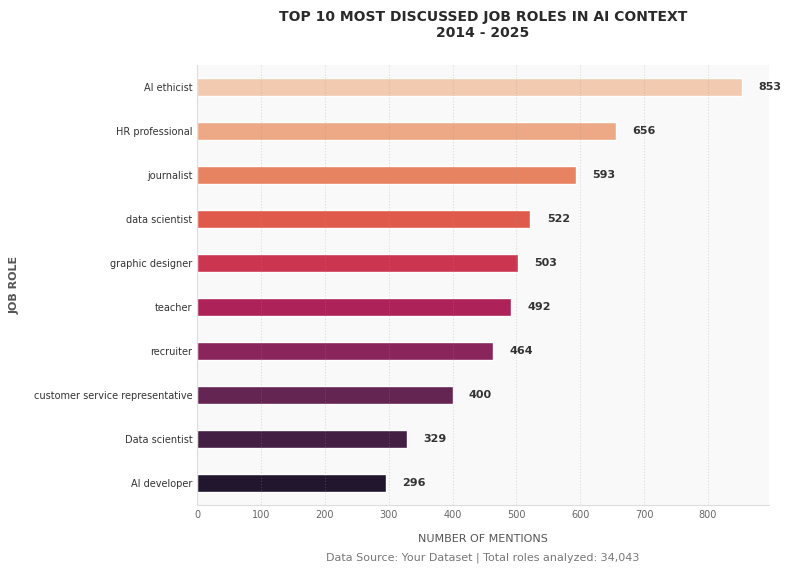


             DATA QUALITY INFORMATION             
▪ Original dataset rows: 34,043
▪ Cleaned dataset rows: 34,043
▪ Rows removed (null 'role' values): 0


In [119]:
from matplotlib import ticker # Import ticker for formatting
from collections import Counter # Import Counter
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("charts", exist_ok=True)

# Ensure the 'date' column is datetime objects
df_jobs_clean = df_jobs.dropna(subset=['role']).copy()
df_jobs_clean['date'] = pd.to_datetime(df_jobs_clean['date'])

min_year = df_jobs_clean['date'].dt.year.min()
max_year = df_jobs_clean['date'].dt.year.max()

role_counts = Counter(df_jobs_clean['role']).most_common(10)
roles_df = pd.DataFrame(role_counts, columns=['Role', 'Count'])


plt.figure(figsize=(8, 6))  # Optimal size for presentations

# Create stylish color palette
custom_palette = sns.color_palette("rocket_r", n_colors=10)

# Create barplot with enhanced style
ax = sns.barplot(
    data=roles_df,
    x='Count',
    y='Role',
    palette=custom_palette,
    saturation=0.85,
    width=0.4,
    edgecolor='white',
    linewidth=1
)

# Customize count labels with modern style
for i, (role, count) in enumerate(zip(roles_df['Role'], roles_df['Count'])):
    ax.text(
        count + max(roles_df['Count'])*0.03,  # Dynamic positioning
        i,
        f"{count:,}",
        va='center',
        ha='left',
        fontsize=8,
        fontweight='semibold',
        color='#333333',
        fontfamily='sans-serif'
    )

# Title and labels with professional styling
plt.title(
    f"TOP 10 MOST DISCUSSED JOB ROLES IN AI CONTEXT\n{min_year} - {max_year}",
    fontsize=10,
    pad=20,
    fontweight='bold',
    color='#2a2a2a',
    fontfamily='sans-serif'
)

plt.xlabel(
    "NUMBER OF MENTIONS",
    fontsize=8,
    labelpad=10,
    fontweight='normal',
    color='#555555',
    fontfamily='sans-serif'
)
plt.ylabel(
    "JOB ROLE",
    fontsize=8,
    labelpad=10,
    fontweight='bold',
    color='#555555',
    fontfamily='sans-serif'
)

# Enhanced grid and spines
ax.xaxis.grid(
    True,
    linestyle=':',
    alpha=0.3,
    color='#999999',
    which='both'
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('#dddddd')
ax.spines['bottom'].set_color('#dddddd')

# Customize ticks and formatting
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='both', which='both', length=0)  # Remove tick marks
plt.xticks(fontsize=7, color='#666666')
plt.yticks(fontsize=7, color='#333333')

# Add subtle background color
ax.set_facecolor('#f9f9f9')
plt.gcf().set_facecolor('#ffffff')

# Add data source annotation
plt.annotate(
    f"Data Source: Your Dataset | Total roles analyzed: {len(df_jobs_clean):,}",
    xy=(0.5, -0.12),
    xycoords='axes fraction',
    ha='center',
    va='center',
    fontsize=8,
    color='#777777'
)

# Final layout adjustment
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for annotation

# Save the plot
plt.savefig("charts/top_10_roles_overall.png", bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

# Data quality info with formatting
print("\n" + "="*50)
print(f"{'DATA QUALITY INFORMATION':^50}")
print("="*50)
print(f"▪ Original dataset rows: {len(df_jobs):,}")
print(f"▪ Cleaned dataset rows: {len(df_jobs_clean):,}")
print(f"▪ Rows removed (null 'role' values): {len(df_jobs) - len(df_jobs_clean):,}")
print("="*50)

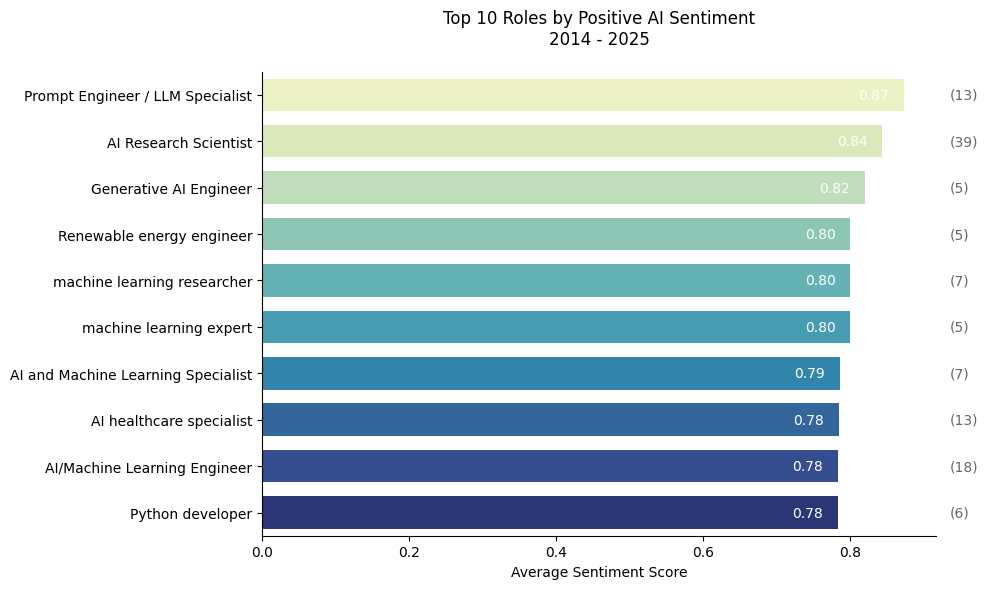


Most positive role: Prompt Engineer / LLM Specialist (Score: 0.87)
Saved to: sentiment_visualizations/top_positive_roles_20250819_120127.png


In [120]:
def visualize_positive_roles(df_jobs, save_dir='sentiment_visualizations'):
    """
    Visualizes top 10 roles by positive sentiment score (with minimum 5 mentions)
    """
    # Setup
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    min_year = df_jobs_clean['date'].dt.year.min()
    max_year = df_jobs_clean['date'].dt.year.max()

    # Data processing
    df_jobs['sentiment_score'] = pd.to_numeric(df_jobs['sentiment_score'], errors='coerce')
    role_sentiment = (df_jobs.groupby('role')['sentiment_score']
                      .agg(['mean', 'count'])
                      .rename(columns={'mean': 'score', 'count': 'mentions'})
                      .query('mentions >= 5')
                      .nlargest(10, 'score')
                      .reset_index())

    # Skip visualization if no data
    if role_sentiment.empty:
        print("No roles met the minimum mention threshold")
        return None

    # Visualization
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=role_sentiment,
                     x='score',
                     y='role',
                     palette='YlGnBu',
                     width=0.7)

    # Add value labels
    for i, (score, mentions) in enumerate(zip(role_sentiment['score'], role_sentiment['mentions'])):
        ax.text(score - 0.02 if score > 0 else score + 0.02,
                i,
                f"{score:.2f}",
                va='center',
                ha='right' if score > 0 else 'left',
                color='white' if score > 0 else '#333333')

        ax.text(1.02, i, f"({mentions})",
                va='center',
                transform=ax.get_yaxis_transform(),
                color='#666666')

    # Styling
    plt.title(f'Top 10 Roles by Positive AI Sentiment\n{min_year} - 2025', pad=20)
    plt.xlabel('Average Sentiment Score')
    plt.ylabel('')
    plt.xlim(left=min(0, role_sentiment['score'].min() * 1.1))
    sns.despine()
    plt.tight_layout()

    # Save and show
    save_path = f"{save_dir}/top_positive_roles_{timestamp}.png"
    plt.savefig(save_path, dpi=120, bbox_inches='tight')
    plt.show()

    # Print summary
    print(f"\nMost positive role: {role_sentiment.iloc[0]['role']} "
          f"(Score: {role_sentiment.iloc[0]['score']:.2f})")
    print(f"Saved to: {save_path}")

    return role_sentiment

# Usage:
positive_roles = visualize_positive_roles(df_jobs)

Total At-Risk Jobs Identified: 7,890
Top 5 Risk Categories:
ai_impact
at_risk            6734
obsolete_role      1152
deskilled_role        2
precarious_role       2
Name: count, dtype: int64




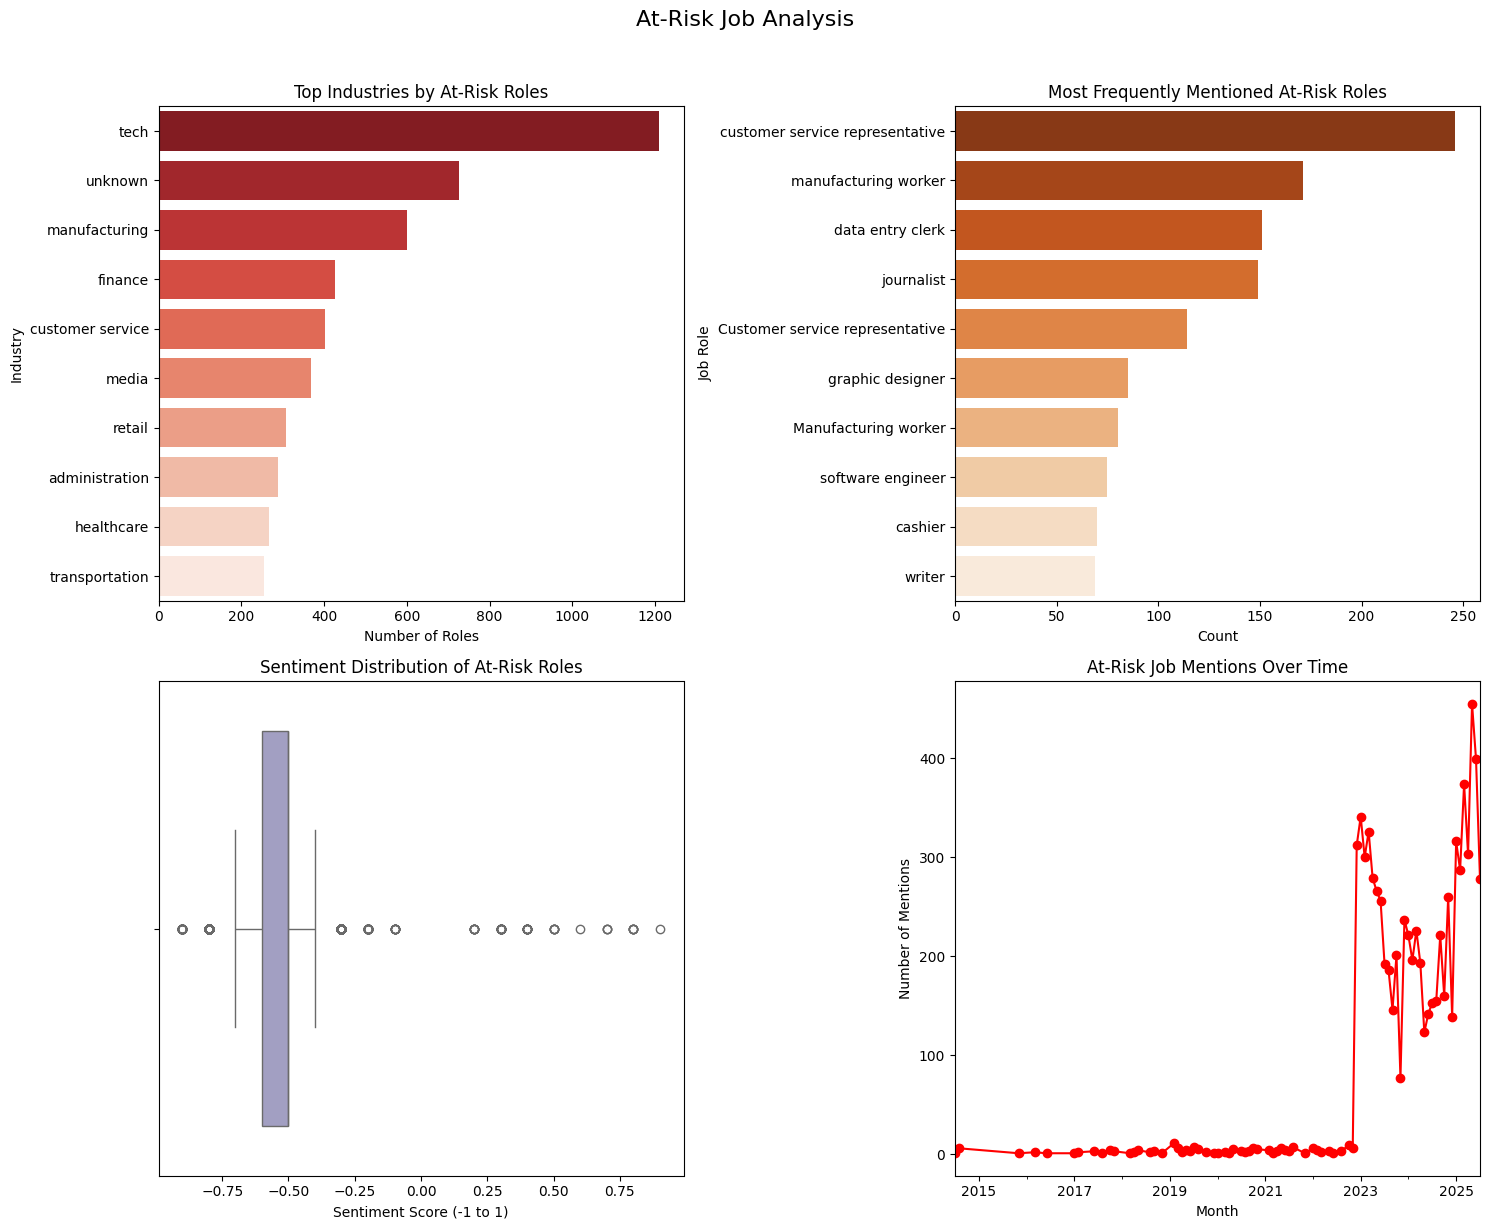

RISK REPORT SUMMARY
- 2880 unique roles identified as at-risk
- Most impacted industry: tech (1208 roles)
- Average sentiment score: -0.54 (scale: -1 to 1)
- Most vulnerable role: 'customer service representative' (mentioned 246 times)


In [123]:
import plotly.express as px

# 1. Filter High-Risk Jobs
risk_categories = ['at_risk', 'obsolete_role', 'precarious_role', 'deskilled_role']
df_risk = df_jobs[df_jobs['ai_impact'].isin(risk_categories)].copy()

# 2. Basic Stats
print("="*50)
print(f"Total At-Risk Jobs Identified: {len(df_risk):,}")
print("Top 5 Risk Categories:")
print(df_risk['ai_impact'].value_counts().head(5))
print("\n")

# 3. Prepare Visualization Data
risk_by_industry = df_risk.groupby('industry').agg(
    num_roles=('role', 'count'),
    avg_sentiment=('sentiment_score', 'mean')
).sort_values('num_roles', ascending=False).head(10)

top_roles = df_risk['role'].value_counts().head(10).reset_index()
top_roles.columns = ['role', 'count']

# 4. Create Visualizations
plt.figure(figsize=(15, 12))
plt.suptitle("At-Risk Job Analysis", fontsize=16, y=1.02)

# Plot 1: Risk Distribution by Industry
plt.subplot(2, 2, 1)
sns.barplot(data=risk_by_industry.reset_index(),
            y='industry', x='num_roles', palette='Reds_r')
plt.title("Top Industries by At-Risk Roles")
plt.xlabel("Number of Roles")
plt.ylabel("Industry")

# Plot 2: Top At-Risk Roles
plt.subplot(2, 2, 2)
sns.barplot(data=top_roles, y='role', x='count', palette='Oranges_r')
plt.title("Most Frequently Mentioned At-Risk Roles")
plt.xlabel("Count")
plt.ylabel("Job Role")

# Plot 3: Sentiment Distribution
plt.subplot(2, 2, 3)
sns.boxplot(data=df_risk, x='sentiment_score', palette='Purples')
plt.title("Sentiment Distribution of At-Risk Roles")
plt.xlabel("Sentiment Score (-1 to 1)")

# Plot 4: Risk Trend Over Time
plt.subplot(2, 2, 4)
time_series = df_risk.groupby(pd.to_datetime(df_risk['date']).dt.to_period('M'))['role'].count()
time_series.plot(kind='line', color='red', marker='o')
plt.title("At-Risk Job Mentions Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Mentions")

plt.tight_layout()
plt.show()

# 6. Generate Risk Report
print("="*50)
print("RISK REPORT SUMMARY")
print(f"- {len(df_risk['role'].unique())} unique roles identified as at-risk")
print(f"- Most impacted industry: {risk_by_industry.index[0]} ({risk_by_industry['num_roles'].iloc[0]} roles)")
print(f"- Average sentiment score: {df_risk['sentiment_score'].mean():.2f} (scale: -1 to 1)")
print(f"- Most vulnerable role: '{top_roles['role'].iloc[0]}' (mentioned {top_roles['count'].iloc[0]} times)")
print("="*50)

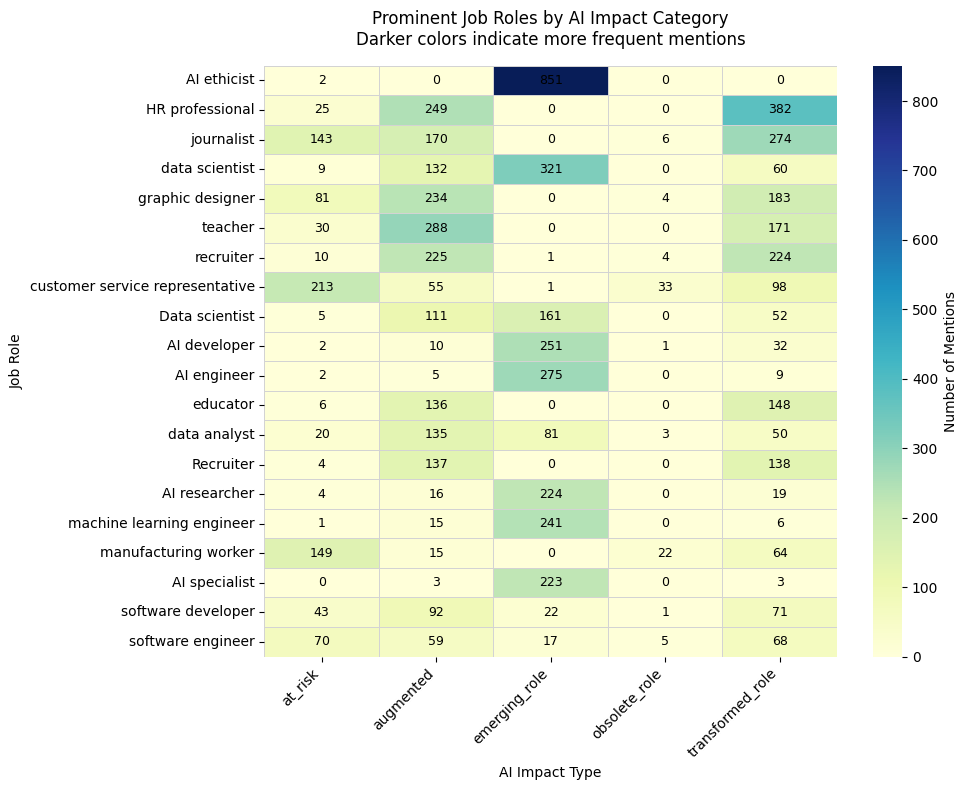

In [124]:
import matplotlib.patheffects as path_effects

def visualize_impact_heatmap(df_jobs, save_dir='heatmap_visualizations'):
    """
    Creates a simplified heatmap of prominent job roles vs specified AI impact types.
    """
    # Create output directory
    os.makedirs(save_dir, exist_ok=True)

    # Filter for only the specified AI impact categories
    target_impacts = ['augmented', 'emerging_role', 'transformed_role', 'at_risk', 'obsolete_role']
    df_filtered = df_jobs[df_jobs['ai_impact'].isin(target_impacts)]

    # Data preparation - count role/impact combinations
    heat_data = (
        df_filtered.groupby(['role', 'ai_impact'])
        .size()
        .unstack(fill_value=0)
    )

    # Filter for prominent roles (top 20 by total mentions)
    prominent_roles = heat_data.sum(axis=1).nlargest(20).index
    heat_data = heat_data.loc[prominent_roles]

    # Create figure with optimized size
    plt.figure(figsize=(10, 8))

    # Create heatmap with clean styling
    ax = sns.heatmap(
        heat_data,
        cmap="YlGnBu",
        annot=True,
        fmt='d',
        annot_kws={'fontsize': 9, 'color': 'black'},
        linewidths=0.5,
        linecolor='lightgray',
        cbar_kws={'label': 'Number of Mentions'}
    )

    # Customize title and labels
    ax.set_title(
        'Prominent Job Roles by AI Impact Category\nDarker colors indicate more frequent mentions',
        fontsize=12,
        pad=15
    )
    ax.set_xlabel('AI Impact Type', fontsize=10)
    ax.set_ylabel('Job Role', fontsize=10)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Adjust layout
    plt.tight_layout()

    # Save and show
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = f"{save_dir}/role_impact_heatmap_{timestamp}.png"
    plt.savefig(save_path, dpi=120, bbox_inches='tight')
    plt.show()

    # Return the filtered data
    return heat_data

# Usage:
impact_heatmap = visualize_impact_heatmap(df_jobs)

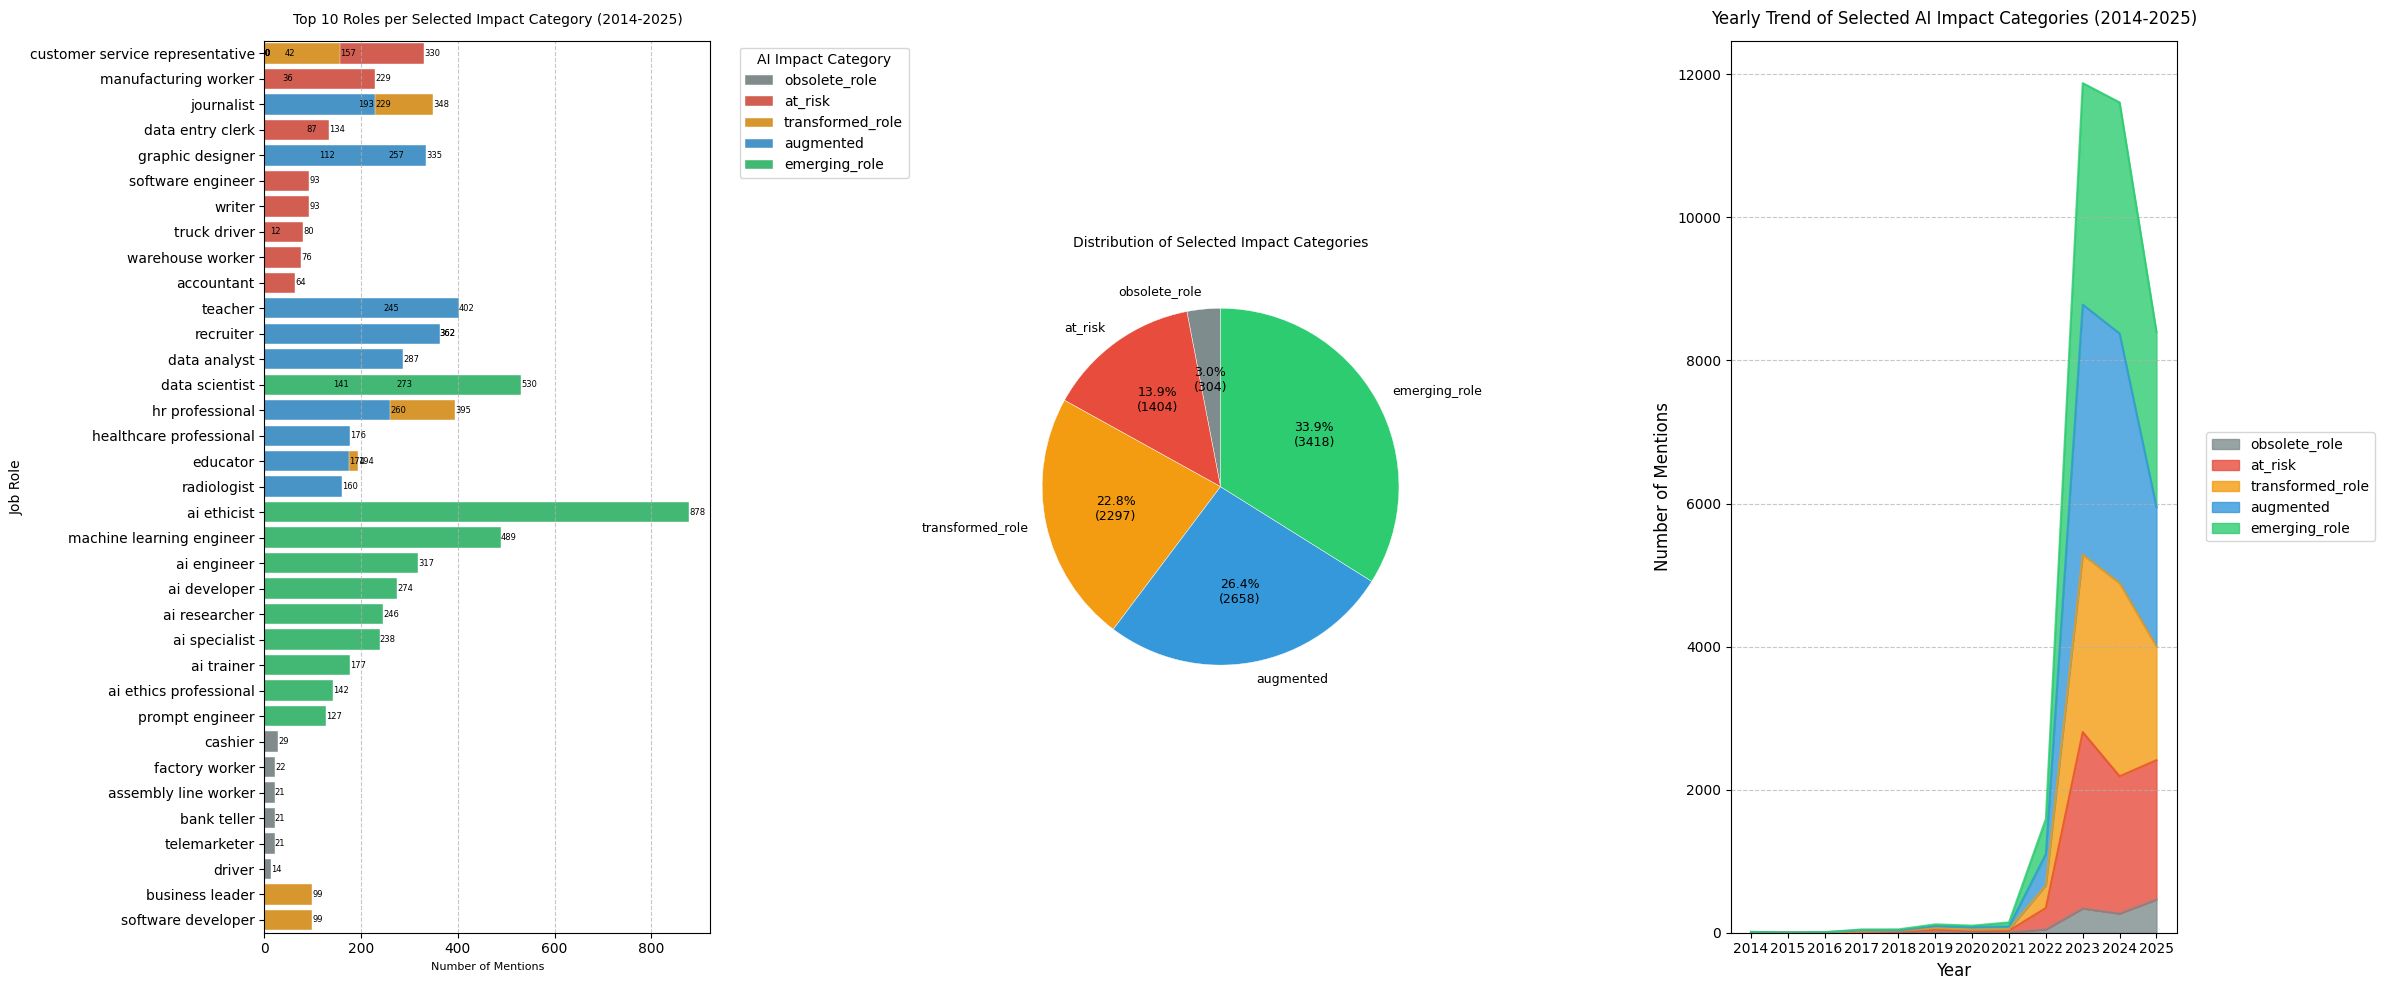


    AI IMPACT ON JOB ROLES ANALYSIS REPORT (Selected Categories)
    Analysis Period: 2014-07-01 to 2025-07-01
    Total Roles Analyzed in Selected Categories: 9,479
    Total Mentions in Selected Categories: 33,947
    Selected Impact Categories: augmented, emerging_role, transformed_role, at_risk, obsolete_role

    MOST MENTIONED ROLE (within selected categories):
    - Role: ai ethicist
    - Impact Category: emerging_role
    - Mentions: 878

    IMPACT CATEGORY DISTRIBUTION (within selected categories):
    ai_impact
augmented           9498
emerging_role       9393
transformed_role    7170
at_risk             6734
obsolete_role       1152

    TREND ANALYSIS (Yearly) for Selected Categories:
    - Earliest year in data: 2014
    - Latest year in data: 2025
    - Total years analyzed: 12

    VISUALIZATIONS SAVED TO:
    - Combined Plot: ai_impact_reports/combined_analysis_20250819_120322.png
    


In [125]:
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator # Import MaxNLocator

def analyze_ai_impact(df_jobs, save_dir='ai_impact_analysis'):
    """
    Analyze and visualize AI impact on job roles with proper date handling,
    correct trend visualization, and separate plot saving.
    """
    # Create output directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

    # 1. Data Preparation - Handle nulls and convert dates
    df_jobs = df_jobs.copy()
    df_jobs['date'] = pd.to_datetime(df_jobs['date'])

    # Filter to only include dates after 2000 (remove any erroneous old dates)
    df_jobs = df_jobs[df_jobs['date'].dt.year >= 2000]

    # --- Add Role Normalization ---
    # Convert role names to lowercase and remove leading/trailing whitespace
    df_jobs['role'] = df_jobs['role'].str.lower().str.strip()
    # Optional: Add more sophisticated normalization if needed (e.g., mapping variations)
    # For example: df_jobs['role'] = df_jobs['role'].replace({'data scientist': 'data scientist'})
    # ----------------------------


    impact_counts = (
        df_jobs.dropna(subset=['ai_impact', 'role'])
        .groupby(['ai_impact', 'role'])
        .size()
        .reset_index(name='count')
    )

    # Define the target impact categories
    target_impact_categories = [
        'augmented',
        'emerging_role',
        'transformed_role',
        'at_risk',
        'obsolete_role'
    ]

    # Filter impact_counts for the target categories
    filtered_impact_counts = impact_counts[impact_counts['ai_impact'].isin(target_impact_categories)]


    # 2. Get top roles with additional metrics from the filtered data
    total_mentions = filtered_impact_counts['count'].sum() # Calculate total mentions from filtered data
    top_roles = (
        filtered_impact_counts
        .assign(percentage=lambda x: x['count'] / total_mentions * 100)
        .sort_values(['ai_impact', 'count'], ascending=[True, False])
        .groupby('ai_impact')
        .head(10)
        .reset_index(drop=True)
    )


    # 3. Enhanced Visualization Setup
    min_date = df_jobs['date'].min()
    max_date = df_jobs['date'].max()
    min_year = min_date.year
    max_year = max_date.year

    # Professional color palette (matching the filtered categories)
    impact_palette = {
        'at_risk': '#E74C3C',
        'augmented': '#3498DB',
        'emerging_role': '#2ECC71',
        'transformed_role': '#F39C12',
        'obsolete_role': '#7F8C8D'
    }

    # Sort impacts by severity (matching the filtered categories)
    impact_order = ['obsolete_role', 'at_risk', 'transformed_role',
                   'augmented', 'emerging_role']


    # 4. Create a single figure with subplots
    # Use `plt.subplots` to create a figure and a set of subplots organized in a 1x3 grid
    fig, axes = plt.subplots(1, 3, figsize=(24, 10)) # 1 row, 3 columns

    # Plot 1: Top Roles Bar Chart (Horizontal) using the filtered data
    sns.barplot(
        data=top_roles,
        x='count',
        y='role',
        hue='ai_impact',
        hue_order=impact_order,
        dodge=False,
        palette=impact_palette,
        edgecolor='w',
        linewidth=0.3,
        ax=axes[0] # Plot on the first subplot
    )

    # Add count labels to bars
    for p in axes[0].patches:
        width = p.get_width()
        axes[0].text(width + 0.2, p.get_y() + p.get_height()/2.,
                f'{int(width)}',
                ha='left', va='center', fontsize=6)

    axes[0].set_title(f"Top 10 Roles per Selected Impact Category ({min_year}-{max_year})", pad=12, fontsize=10)
    axes[0].set_xlabel("Number of Mentions", fontsize=8)
    axes[0].set_ylabel("Job Role", fontsize=10)
    axes[0].legend(title="AI Impact Category", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(axis='x', linestyle='--', alpha=0.7)


    # Plot 2: Impact Distribution Pie Chart (on the second subplot) using the filtered data
    impact_dist = top_roles.groupby('ai_impact')['count'].sum()
    impact_dist = impact_dist.reindex(impact_order).dropna()

    axes[1].pie(impact_dist,
            labels=impact_dist.index,
            colors=[impact_palette[i] for i in impact_dist.index],
            autopct=lambda p: f'{p:.1f}%\n({int(p/100*impact_dist.sum())})',
            startangle=90,
            textprops={'fontsize': 9},
            wedgeprops={'edgecolor':'white', 'linewidth':0.3})
    axes[1].set_title("Distribution of Selected Impact Categories", pad=12, fontsize=10)


    # Plot 3: Corrected Time Trend Analysis (Yearly) using the filtered data
    # Group by Year and AI Impact to get yearly counts
    time_trend = (
        df_jobs[df_jobs['ai_impact'].isin(target_impact_categories)] # Filter df_jobs before grouping for time trend
        .groupby([df_jobs['date'].dt.year, 'ai_impact']) # Group by Year
        .size()
        .unstack()
        .fillna(0)
    )

    # Ensure all filtered impact categories are represented and in correct order
    for impact in impact_order:
        if impact not in time_trend.columns:
            time_trend[impact] = 0

    time_trend = time_trend[impact_order]

    # Plot with proper year formatting
    time_trend.plot(kind='area',
                       stacked=True,
                       color=[impact_palette[i] for i in time_trend.columns],
                       alpha=0.8,
                       ax=axes[2]) # Plot on the third subplot

    # Format x-axis to show years clearly
    axes[2].xaxis.set_major_locator(MaxNLocator(integer=True)) # Ensure only integer years are shown
    axes[2].set_xticks(time_trend.index.astype(int)) # Set x-ticks to the actual years


    axes[2].set_title(f"Yearly Trend of Selected AI Impact Categories ({min_year}-2025)", pad=12, fontsize=12)
    axes[2].set_xlabel("Year", fontsize=12)
    axes[2].set_ylabel("Number of Mentions", fontsize=12)
    axes[2].legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)


    # Adjust layout to prevent overlapping titles and labels
    plt.tight_layout()

    # Save the combined figure
    combined_img_path = os.path.join(save_dir, f'combined_analysis_{current_time}.png')
    plt.savefig(combined_img_path, bbox_inches='tight', dpi=100)
    plt.close(fig) # Close the figure after saving


    # 5. Generate Text Summary
    most_impacted = top_roles.sort_values('count', ascending=False).iloc[0] # Get most mentioned role from top_roles
    impact_dist = filtered_impact_counts.groupby('ai_impact')['count'].sum().sort_values(ascending=False) # Distribution from filtered data

    summary_text = f"""
    AI IMPACT ON JOB ROLES ANALYSIS REPORT (Selected Categories)
    =============================================================
    Analysis Period: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}
    Total Roles Analyzed in Selected Categories: {len(filtered_impact_counts):,}
    Total Mentions in Selected Categories: {total_mentions:,}
    Selected Impact Categories: {', '.join(target_impact_categories)}

    MOST MENTIONED ROLE (within selected categories):
    - Role: {most_impacted['role']}
    - Impact Category: {most_impacted['ai_impact']}
    - Mentions: {most_impacted['count']:,}

    IMPACT CATEGORY DISTRIBUTION (within selected categories):
    {impact_dist.to_string()}

    TREND ANALYSIS (Yearly) for Selected Categories:
    - Earliest year in data: {min_year}
    - Latest year in data: {max_year}
    - Total years analyzed: {len(time_trend):,}

    VISUALIZATIONS SAVED TO:
    - Combined Plot: {combined_img_path}
    """

    # Save text summary
    summary_path = os.path.join(save_dir, f'summary_{current_time}.txt')
    with open(summary_path, 'w') as f:
        f.write(summary_text)


    # 6. Display the combined plot and text summary in notebook
    from IPython.display import display, Image
    display(Image(filename=combined_img_path))

    # Print summary to console
    print(summary_text)


    # 7. Return statistical insights and paths
    stats = {
        'analysis_period': {'start': min_date, 'end': max_date},
        'total_roles_analyzed_selected': len(filtered_impact_counts),
        'total_mentions_selected': total_mentions,
        'most_mentioned_role_selected': most_impacted.to_dict(),
        'impact_category_distribution_selected': impact_dist.to_dict(),
        'time_trend_data_selected': time_trend,
        'saved_files': {
            'combined_plot': combined_img_path,
            'summary': summary_path
        }
    }


    return stats

# Usage:
impact_stats = analyze_ai_impact(df_jobs, save_dir='ai_impact_reports')

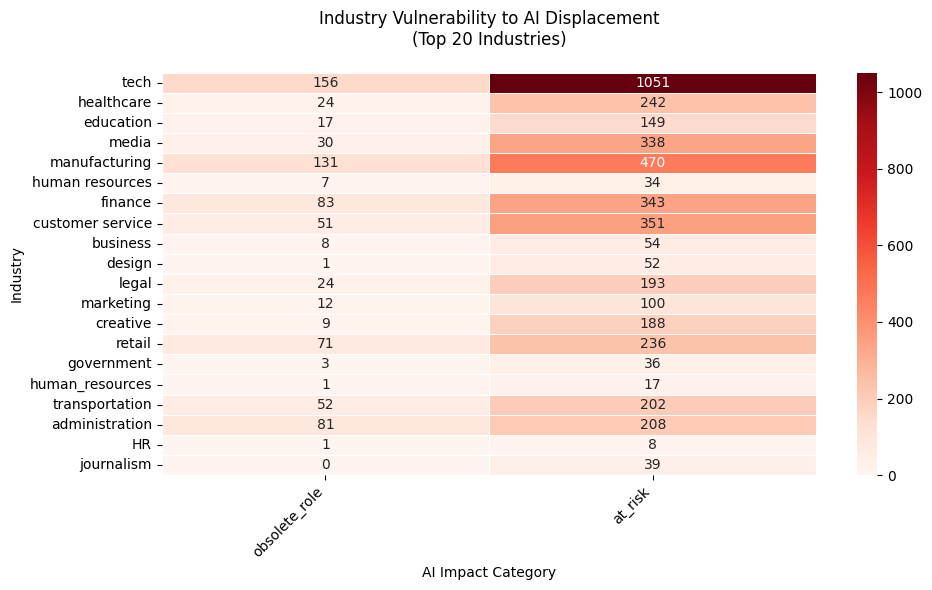

Showing top 20 industries (excluding 'unknown')
Industries analyzed: tech, healthcare, education, media, manufacturing...


In [127]:
# Filter out 'unknown' industry first
df_filtered = df_jobs[df_jobs['industry'] != 'unknown']

# Aggregate data to count occurrences of each industry, role, and ai_impact combination
pivot = df_filtered.pivot_table(index='industry',
                               columns='ai_impact',
                               values='article_id',
                               aggfunc='count',
                               fill_value=0)

# Filter for the top N industries based on total mentions
top_n_industries = 20
top_industries = pivot.sum(axis=1).nlargest(top_n_industries).index
pivot_filtered = pivot.loc[top_industries]

plt.figure(figsize=(10, 6))  # Increased size for better readability
sns.heatmap(pivot_filtered[['obsolete_role','at_risk']],
            annot=True,
            fmt='d',
            cmap='Reds',
            linewidths=0.5,
            linecolor='white')
plt.title(f'Industry Vulnerability to AI Displacement\n(Top {top_n_industries} Industries)',
          pad=20, fontsize=12)
plt.xlabel('AI Impact Category')
plt.ylabel('Industry')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Print summary
print(f"Showing top {len(top_industries)} industries (excluding 'unknown')")
print(f"Industries analyzed: {', '.join(top_industries[:5])}...")  # Show first

In [ ]:
!pip install squarify

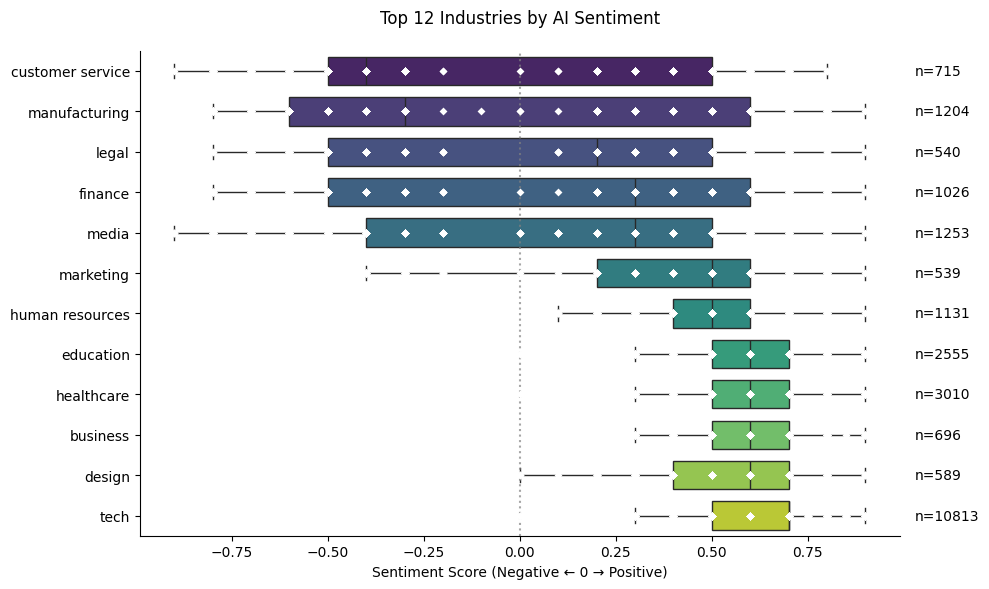

Showing top 12 industries (excluding 'unknown')
Total samples: 24071


In [128]:
def visualize_prominent_industries(df_jobs, n_industries=12):
    """
    Focused boxplot of sentiment for top prominent industries, excluding 'unknown'.
    """
    # Filter out 'unknown' industry first
    df_filtered = df_jobs[df_jobs['industry'] != 'unknown']

    # Get top industries by mention count (excluding unknown)
    industry_counts = df_filtered['industry'].value_counts()
    top_industries = industry_counts.nlargest(n_industries).index

    # Filter and clean data
    df_clean = df_filtered[
        df_filtered['industry'].isin(top_industries) &
        df_filtered['sentiment_score'].notna()
    ]

    # Sort by median sentiment
    industry_order = (
        df_clean.groupby('industry')['sentiment_score']
        .median()
        .sort_values()
        .index
    )

    # Create visualization
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(
        data=df_clean,
        x='sentiment_score',
        y='industry',
        order=industry_order,
        palette='viridis',
        width=0.7,
        linewidth=1,
        showfliers=False  # Remove outliers for cleaner look
    )

    # Add mean markers
    sns.stripplot(
        data=df_clean,
        x='sentiment_score',
        y='industry',
        order=industry_order,
        color='white',
        edgecolor='black',
        size=4,
        marker='D',
        jitter=False
    )

    # Enhance readability
    plt.title(f'Top {n_industries} Industries by AI Sentiment', pad=20)
    plt.xlabel('Sentiment Score (Negative ← 0 → Positive)')
    plt.ylabel('')
    plt.axvline(0, color='gray', linestyle=':', alpha=0.7)

    # Add value counts
    for i, industry in enumerate(industry_order):
        count = industry_counts[industry]
        ax.text(1.02, i, f'n={count}', va='center', transform=ax.get_yaxis_transform())

    sns.despine()
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"Showing top {len(industry_order)} industries (excluding 'unknown')")
    print(f"Total samples: {len(df_clean)}")

# Usage
visualize_prominent_industries(df_jobs)

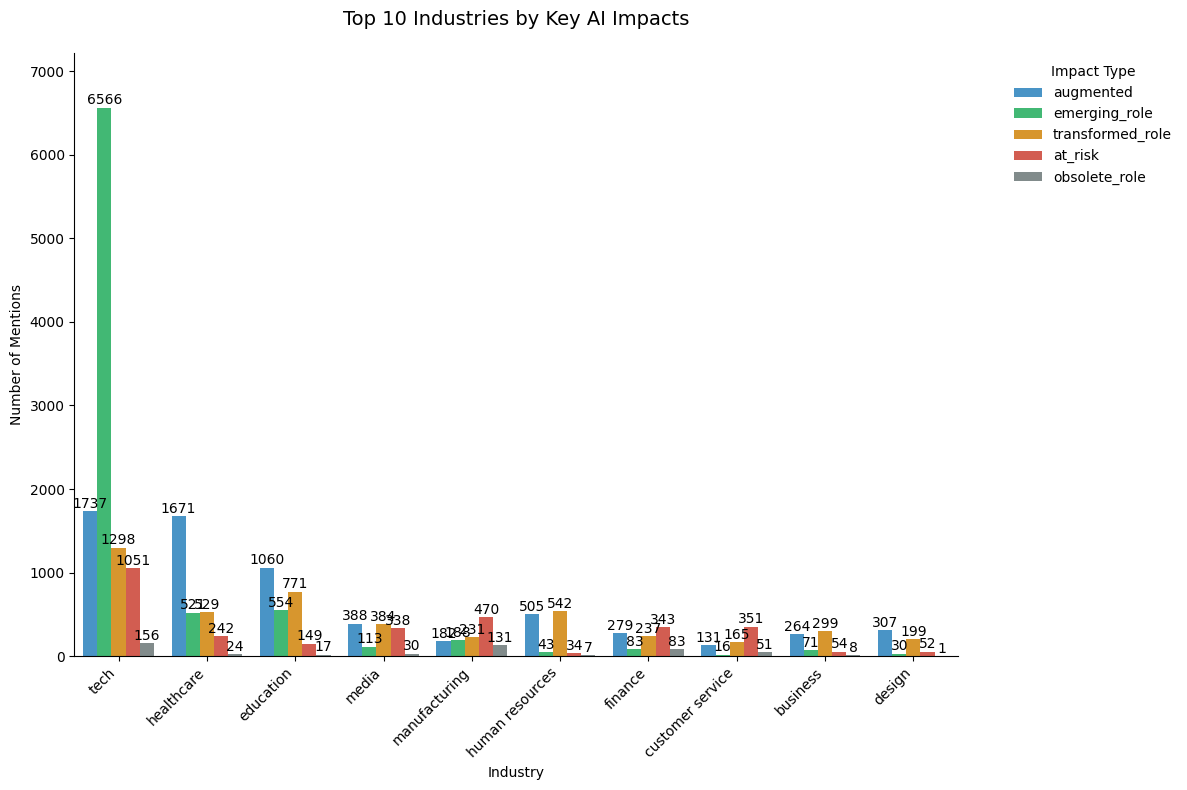

Showing top 10 industries (excluding 'unknown')
Total mentions shown: 22956


In [129]:
def visualize_key_impacts_vertical(df_jobs, top_n=10):
    """
    Vertical bar chart of key AI impacts across prominent industries
    with wider bars for better visibility, excluding 'unknown' industry.
    """
    # Filter for only the important impact categories and exclude 'unknown' industry
    key_impacts = ['augmented', 'emerging_role', 'transformed_role', 'at_risk', 'obsolete_role']
    df_filtered = df_jobs[
        (df_jobs['ai_impact'].isin(key_impacts)) &
        (df_jobs['industry'] != 'unknown')
    ].copy()

    # Get top industries (excluding 'unknown')
    top_industries = df_filtered['industry'].value_counts().nlargest(top_n).index
    df_filtered = df_filtered[df_filtered['industry'].isin(top_industries)]

    # Create vertical count plot with wider bars
    plt.figure(figsize=(12, 8))
    ax = sns.countplot(
        data=df_filtered,
        x='industry',
        hue='ai_impact',
        order=top_industries,
        palette={
            'augmented': '#3498db',
            'emerging_role': '#2ecc71',
            'transformed_role': '#f39c12',
            'at_risk': '#e74c3c',
            'obsolete_role': '#7f8c8d'
        },
        hue_order=key_impacts,
        width=0.8
    )

    # Improve readability
    plt.title(f'Top {top_n} Industries by Key AI Impacts', pad=20, fontsize=14)
    plt.ylabel('Number of Mentions')
    plt.xlabel('Industry')
    plt.xticks(rotation=45, ha='right')

    # Adjust legend position
    plt.legend(
        title='Impact Type',
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        frameon=False
    )

    # Add count labels on top of bars
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width()/2.,
                    height + 3,
                    f'{int(height)}',
                    ha='center',
                    va='bottom',
                    fontsize=10)

    # Adjust spacing
    plt.margins(y=0.1)
    sns.despine()
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"Showing top {len(top_industries)} industries (excluding 'unknown')")
    print(f"Total mentions shown: {len(df_filtered)}")

# Usage:
visualize_key_impacts_vertical(df_jobs, top_n=10)

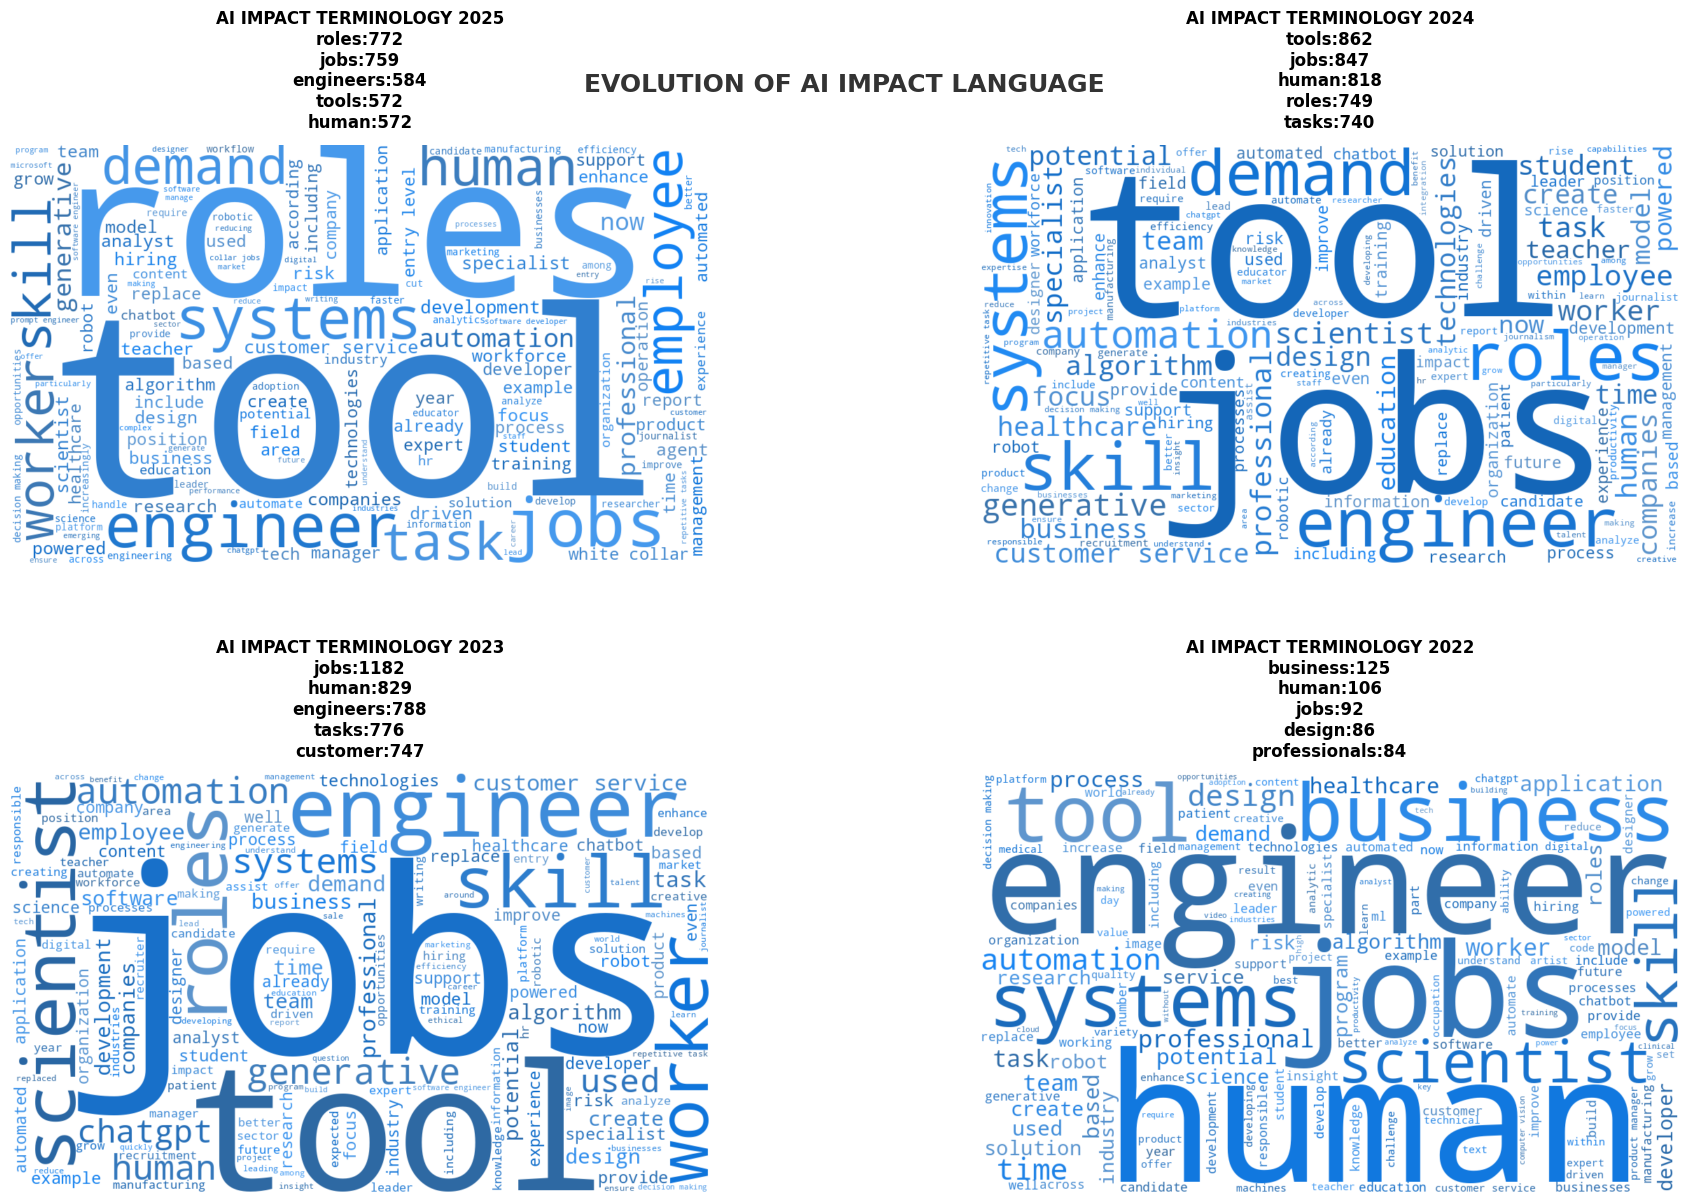


✅ Word clouds saved to: /content/ai_wordclouds


4

In [130]:
from wordcloud import WordCloud, STOPWORDS

def generate_year_wordclouds(df, years=None, figsize=(20, 12), cols=2,
                           output_dir="wordclouds", mask_shape=None):
    """
    Generate professional word clouds for specific years with enhanced customization.

    Parameters:
        df (pd.DataFrame): Input dataframe
        years (list): Years to analyze (default: all available years)
        figsize (tuple): Figure size
        cols (int): Number of columns in grid
        output_dir (str): Directory to save word clouds
        mask_shape (str): Shape for word cloud ('circle', 'rectangle', or None)
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Set years if not provided
    if years is None:
        years = sorted(df['date'].dt.year.unique(), reverse=True)
    else:
        years = sorted(years, reverse=True)

    # Calculate grid layout
    rows = -(-len(years) // cols)  # Ceiling division

    # Create figure with white background
    fig = plt.figure(figsize=figsize, facecolor='white')

    # Custom color function (blue theme)
    def color_func(word, font_size, position, orientation, random_state, **kwargs):
        hue = 210  # Blue base hue
        saturation = 70 + random_state.randint(-20, 20)
        lightness = 50 + random_state.randint(-10, 10)
        return f"hsl({hue}, {saturation}%, {lightness}%)"

    # Mask configuration
    if mask_shape == "circle":
        x, y = np.ogrid[:800, :800]
        mask = (x - 400) ** 2 + (y - 400) ** 2 > 400 ** 2
        mask = 255 * mask.astype(int)
    else:
        mask = None

    # Extended stopwords - Added more common and less meaningful terms
    extra_stopwords = {
        'ai', 'artificial', 'intelligence', 'will', 'use', 'using',
        'can', 'new', 'technology', 'also', 'would', 'could', 'get',
        'make', 'made', 'one', 'many', 'much', 'like', 'see', 'says',
        'said', 'have', 'has', 'had', 'go', 'going', 'went', 'know',
        'get', 'gets', 'getting', 'want', 'wants', 'wanted', 'take',
        'takes', 'taken', 'come', 'comes', 'coming', 'look', 'looks',
        'looked', 'tell', 'tells', 'told', 'give', 'gives', 'given',
        'find', 'finds', 'found', 'seem', 'seems', 'seemed', 'feel',
        'feels', 'felt', 'become', 'becomes', 'became', 'leave', 'leaves',
        'left', 'mean', 'means', 'meant', 'put', 'puts', 'putting',
        'keep', 'keeps', 'kept', 'begin', 'begins', 'began', 'show',
        'shows', 'showed', 'hear', 'hears', 'heard', 'run', 'runs',
        'ran', 'turn', 'turns', 'turned', 'bring', 'brings', 'brought',
        'start', 'starts', 'started', 'help', 'helps', 'helped', 'write',
        'writes', 'written', 'read', 'reads', 'read', 'stand', 'stands',
        'stood', 'lose', 'loses', 'lost', 'pay', 'pays', 'paid', 'allow',
        'allows', 'allowed', 'must', 'should', 'may', 'might', 'need',
        'needs', 'needed', 'want', 'wants', 'wanted', 'able', 'able',
        'able', 'able', 'way', 'work', 'job', 'role', 'people', 'system',
        'data', 'machine', 'learning'
    }
    stopwords = STOPWORDS.union(extra_stopwords)

    for i, year in enumerate(years, 1):
        # Filter data
        df_year = df[df['date'].dt.year == year]
        if len(df_year) == 0:
            print(f"⚠️ No data for year {year}")
            continue

        # Prepare text
        text = " ".join(df_year["evidence"].dropna().astype(str))
        if not text.strip():
            print(f"⚠️ No evidence text for year {year}")
            continue

        # Generate word frequencies for tooltip
        word_freq = Counter(text.lower().split())
        # Remove stopwords from word frequency calculation for tooltip
        filtered_word_freq = {word: freq for word, freq in word_freq.items() if word not in stopwords}
        top_words = dict(sorted(filtered_word_freq.items(), key=lambda x: x[1], reverse=True)[:5])


        # Create word cloud
        wc = WordCloud(
            width=1000,
            height=600,
            background_color='white',
            max_words=150,
            stopwords=stopwords,
            mask=mask,
            contour_width=1,
            contour_color='steelblue',
            color_func=color_func,
            min_font_size=8,
            prefer_horizontal=0.9,
            relative_scaling=0.5
        ).generate(text)

        # Save high-quality version
        filename = f"wordcloud_{year}.png"
        wc.to_file(os.path.join(output_dir, filename))

        # Create subplot
        ax = fig.add_subplot(rows, cols, i)
        ax.imshow(wc, interpolation='bilinear')

        # Enhanced title with word count
        ax.set_title(
            f"AI IMPACT TERMINOLOGY {year}\n" +
            "\n".join([f"{k}:{v}" for k,v in top_words.items()]),
            fontsize=12,
            pad=12,
            fontweight='bold'
        )
        ax.axis("off")

        # Add subtle border
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('#f0f0f0')
            spine.set_linewidth(2)

    # Final adjustments
    plt.tight_layout(pad=4)
    plt.subplots_adjust(top=0.92)
    fig.suptitle(
        "EVOLUTION OF AI IMPACT LANGUAGE",
        fontsize=18,
        y=0.98,
        fontweight='bold',
        color='#333333'
    )

    # Save combined visualization
    plt.savefig(
        os.path.join(output_dir, "wordclouds_combined.png"),
        dpi=300,
        bbox_inches='tight',
        facecolor='white'
    )

    plt.show()

    print(f"\n✅ Word clouds saved to: {os.path.abspath(output_dir)}")
    return len(years)

# Example usage:
generate_year_wordclouds(
    df_jobs,
    years=[2025, 2024, 2023, 2022],
    output_dir="ai_wordclouds"
)

category
training_upskilling            5057
ai_governance_ethics           4037
worker_protection              1248
economic_transition_support     998
innovation_incentives           381
Name: count, dtype: int64


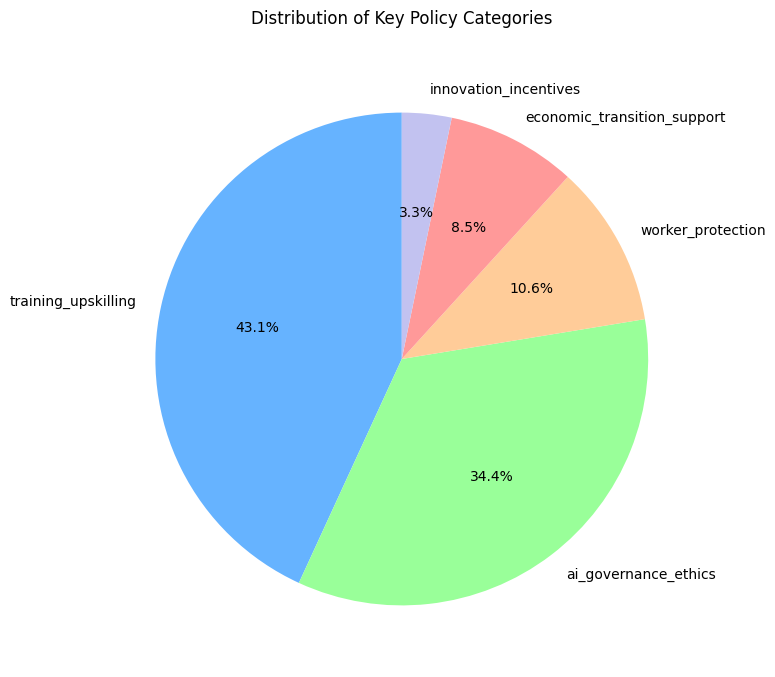

In [131]:
prominent_categories = [
    'training_upskilling',
    'ai_governance_ethics',
    'worker_protection',
    'economic_transition_support',
    'innovation_incentives'
]

# Filter the DataFrame
df_policies_filtered = df_policies[df_policies['category'].isin(prominent_categories)]
policy_counts = df_policies_filtered['category'].value_counts()
print(policy_counts)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
policy_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff','#99ff99','#ffcc99','#ff9999','#c2c2f0']
)
plt.title('Distribution of Key Policy Categories', pad=20)
plt.ylabel('')  # Removes default 'None' label
plt.show()

In [132]:
# Load the results from the JSON file
sample_df = pd.read_json("/content/drive/MyDrive/sentiment_analysis/sample_df.json")

# Display the first few rows of the loaded DataFrame
print(results_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 21996 entries, 0 to 22006
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   article_id              21996 non-null  int64         
 1   date                    21996 non-null  datetime64[ns]
 2   job_roles               21996 non-null  object        
 3   policy_recommendations  21996 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 859.2+ KB
None


In [134]:
import pandas as pd
from IPython.display import display, HTML
import re # Import re for context highlighting

def verify_role_classification(article_id):
    """
    Verify job role classification by comparing original text with analysis results.

    Args:
        article_id (int): The article ID to verify

    Returns:
        dict: Verification results with evidence highlights
    """
    # Find the row in the sample_df (which replaced the original df in this notebook state)
    original = sample_df[sample_df['index'] == article_id]
    if original.empty:
        return {"error": f"Article ID {article_id} not found in sample data"}

    # Find the row in the results_df
    analysis_result = results_df[results_df['article_id'] == article_id] # Corrected variable name
    if analysis_result.empty:
        return {"error": f"Article ID {article_id} not found in analyzed data"}

    # Extract relevant data - using columns available in sample_df
    original_text = original['cleaned_text'].iloc[0] # Use cleaned_text from sample_df
    original_title = original['title_dl'].iloc[0] # Use title_dl from sample_df

    # Access the list of job roles from the 'job_roles' column in analysis_result
    roles_list = analysis_result['job_roles'].iloc[0]

    verification_results = {
        "article_id": article_id,
        "title": original_title, # Use extracted title
        "date": analysis_result['date'].iloc[0].strftime('%Y-%m-%d'), # Use date from results_df
        "roles": []
    }

    # Verify each classified role
    for role in roles_list: # Iterate through the list of role dictionaries
        role_name = role.get('role')
        evidence = role.get('evidence', '') # Use .get for safety and default to empty string

        # Check if evidence appears in original text
        # Use re.IGNORECASE for case-insensitive matching
        evidence_match = re.search(re.escape(evidence), original_text, re.IGNORECASE)
        evidence_found_in_text = evidence_match is not None

        # Find context around evidence (if present)
        context = "Evidence not found in original text"
        if evidence_found_in_text:
            start_pos = evidence_match.start()
            end_pos = evidence_match.end()
            # Get context before and after, highlight the evidence
            context_before = original_text[max(0, start_pos-100):start_pos]
            context_evidence = original_text[start_pos:end_pos]
            context_after = original_text[end_pos:min(len(original_text), end_pos+100)]
            context = f"...{context_before}<mark>{context_evidence}</mark>{context_after}..."


        verification_results['roles'].append({
            "role": role_name,
            "ai_impact": role.get('ai_impact', 'N/A'), # Use .get for safety
            "evidence": evidence,
            "evidence_found_in_text": evidence_found_in_text,
            "context": context,
            "sentiment_score": role.get('sentiment_score', None), # Use .get for safety
            "confidence": role.get('confidence', None) # Use .get for safety
        })

    return verification_results

def display_verification(results):
    """Pretty display verification results using HTML"""
    if 'error' in results:
        display(HTML(f"<h3 style='color:red'>{results['error']}</h3>"))
        return

    display(HTML(f"""
    <h3>Verification for Article ID {results['article_id']}</h3>
    <p><strong>Title:</strong> {results['title']}</p>
    <p><strong>Date:</strong> {results['date']}</p>
    <hr>
    <h4>Role Classification Verification</h4>
    """))

    if not results['roles']:
        display(HTML("<p>No job roles were extracted for this article.</p>"))
        return

    for role in results['roles']:
        status_color = "green" if role['evidence_found_in_text'] else "red"
        status_text = "✓ Evidence Found" if role['evidence_found_in_text'] else "✗ Evidence Not Found"

        display(HTML(f"""
        <div style='margin-bottom: 20px; border: 1px solid #eee; padding: 15px; border-left: 4px solid {status_color};'>
            <p style='margin: 0;'><strong>Role:</strong> {role['role']} ({role['ai_impact']})</p>
            <p style='margin: 5px 0;'><strong>Status:</strong> <span style='color:{status_color};'>{status_text}</span></p>
            <p style='margin: 5px 0;'><strong>Evidence Snippet:</strong> <code>"{role['evidence']}"</code></p>
            <p style='margin: 5px 0;'><strong>Sentiment:</strong> {role['sentiment_score']} (Confidence: {role['confidence']})</p>
            <p style='margin: 5px 0;'><strong>Context in Original Text:</strong> {role['context']}</p>
        </div>
        """))

In [135]:
# Example usage: Replace with an article_id that exists in your results_df
article_to_check = 3 # 2953 # Example 20201, 2926, 1342
verification = verify_role_classification(article_to_check)
display_verification(verification)

  {
    "index":3,
    "date":1447027200000,
    "title_dl":"report finds rise of artificial intelligence could spark mass unemployment and inequality",
    "cleaned_text":"fears about human workers losing their jobs to machines have been fueled by a percent increase in the number of industrial robots in the u.s. over the past decade although with investment in artificial intelligence soaring things could be about to get a lot worse. this is according to a new page report by bank of america merrill lynch which details the potential impact of the impending robot revolution on the job market. the report claims that advances in robotics and ai are leading to a phenomenon known as creative disruption whereby benefits in the shape of increased productivity and reduced costs are offset against disruptions to labor markets with huge numbers of workers set to lose out.  
    for instance a san francisco based start up has created a fully automated burger flipping machine which is being tipped to replace `workers in fast food restaurants`.   
    elsewhere plans have been announced to introduce fully intelligent robot police officers in the united arab emirates before the end of the decade with the intention of providing better services without hiring. while this may sound. as a result it is claimed that the combination of ai machine learning deep learning and natural user interfaces are making it possible to automate many knowledge worker tasks that were long regarded as impossible or impractical for machines to perform. according to ray kurzweil director of engineering at google this could soon lead to what he calls the singularity whereby sentient devices overtake humans as the most intelligent beings on the planet. on a slightly less apocalyptic but equally alarming note the baml report suggests that the rise of automated workforces could result in social and economic inequality as wealth becomes concentrated among business owners. this could generate winner takes all and monopolistic outcomes with the proprietors of technological patents accumulating huge amounts of wealth while unskilled workers struggle. for instance while the introduction of technology to agricultural processes may have replaced man hours on farms it. many will be hoping for a similar effect as new robotic technologies continue to revolutionize the global workspace leading to what baml is calling a paradigm shift which will change the way we live and work.
  },